**Modelo de Prediccion de Precios de viviendas. Se trabaja sobre un dataset de ventas de propiedades del centro de alguna ciudad para predecir el precio por m2 en Unidades de fomento.**


El desafío es:

* Realizar un Análisis exploratorio de los datos.
* Limpiar y preparar los datos para el modelado.
* Identificar variables con valor predictivo que ayuden a predecir el precio_uf_m2.
* Entrenar un modelo predictivo que tenga el menor RMSE posible (el cual debe ser menor a 7) cuando sea evaluado contra un subconjunto de datos de validación.
* Agregar celdas markdown y celdas de código para crear una solución a este desafío.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as pyplot
import math
import numpy as np



In [2]:
df =pd.read_csv('datos_prueba.csv',index_col=0)
df.head(10)

,fecha_venta,antiguedad_propiedad,distancia_al_metro,tiendas_cercanas,latitud,longitud,precio_uf_m2
0,2013.333,10.8,252.5822,1.0,-33.46459999999999,-70.63046,117.5
1,2013.333,37.2,186.5101,9.0,-33.467029999999994,-70.64265,78.3
2,2013.583,35.4,318.5292,9.0,-33.46070999999999,-70.64069,78.0
3,2013.417,0.0,292.9978,6.0,-33.46744,-70.64458,73.6
4,2012.833,0.0,292.9978,6.0,-33.46744,-70.64458,71.0
5,2013.250,0.0,292.9978,6.0,-33.46744,-70.64458,70.1
6,2013.333,0.0,292.9978,6.0,-33.46744,-70.64458,69.7
7,2013.250,40.9,122.3619,8.0,-33.457559999999994,-70.64230,67.7
8,2013.500,15.3,370.0000,1.0,NaN,NaN,66.0
9,2012.833,15.3,370.0000,1.0,NaN,NaN,66.0


    1.- Análisis exploratorio de datos

In [3]:
df.columns=['fecha','a_prop','dist_m','t_cerc','lat','long','uf_m2']
df.shape # cantidad de datos

(450, 7)

In [4]:
df.info() #cambiamos las variables de cualquier tipo a numéricas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   449 non-null    float64
 1   a_prop  446 non-null    float64
 2   dist_m  445 non-null    float64
 3   t_cerc  436 non-null    float64
 4   lat     433 non-null    object 
 5   long    431 non-null    float64
 6   uf_m2   450 non-null    float64
dtypes: float64(6), object(1)
memory usage: 28.1+ KB


In [5]:
is_NaN=df.isnull() #verificamos datos nulos
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]


In [6]:
print(rows_with_NaN)

        fecha  a_prop  dist_m  t_cerc   lat  long  uf_m2
8    2013.500    15.3   370.0     1.0   NaN   NaN   66.0
9    2012.833    15.3   370.0     1.0   NaN   NaN   66.0
22   2012.917    23.5   423.0     NaN   NaN   NaN   60.0
23   2013.333    23.5   423.0     NaN   NaN   NaN   60.0
51   2013.083     4.2   243.0     NaN   NaN   NaN   54.0
52   2012.083     4.2   243.0     NaN   NaN   NaN   54.0
139  2013.500    14.1     3.0   500.0   NaN   NaN   44.0
141  2013.583    14.1     3.0   500.0   NaN   NaN   44.0
208  2013.000     NaN     NaN     NaN  nan,   NaN   40.0
279  2012.250    13.3   303.0     NaN   NaN   NaN   34.0
280  2012.667    13.3   303.0     NaN   NaN   NaN   34.0
281  2012.250    33.3   533.0     NaN   NaN   NaN   34.0
282  2012.917    33.3   533.0     NaN   NaN   NaN   34.0
296       NaN     NaN     NaN     NaN   NaN   NaN   32.0
317  2013.417     NaN     NaN     NaN  nan,   NaN   30.0
386  2013.083     NaN     NaN     NaN   NaN   NaN   23.0
392  2013.500    25.5     NaN  

In [7]:
df=df.fillna(0) #cambiamos valores nulos por cero. Puede haber correlacion entre las variables restantes y el objetivo 
# por lo que no se eliminan


In [8]:
df.head(100)

,fecha,a_prop,dist_m,t_cerc,lat,long,uf_m2
0,2013.333,10.8,252.5822,1.0,-33.46459999999999,-70.63046,117.5
1,2013.333,37.2,186.5101,9.0,-33.467029999999994,-70.64265,78.3
2,2013.583,35.4,318.5292,9.0,-33.46070999999999,-70.64069,78.0
3,2013.417,0.0,292.9978,6.0,-33.46744,-70.64458,73.6
4,2012.833,0.0,292.9978,6.0,-33.46744,-70.64458,71.0
...,...,...,...,...,...,...,...
95,2013.083,13.2,150.9347,7.0,-33.457249999999995,-70.64252,48.1
96,2013.333,19.2,383.7129,8.0,-33.462,-70.64477,48.1
97,2013.500,13.6,492.2313,5.0,-33.45515,-70.63737,48.0
98,2012.917,8.9,1406.4300,0.0,-33.47573,-70.62758,48.0


In [9]:
is_NaN=df.isnull()

In [10]:
print(is_NaN)

     fecha  a_prop  dist_m  t_cerc    lat   long  uf_m2
0    False   False   False   False  False  False  False
1    False   False   False   False  False  False  False
2    False   False   False   False  False  False  False
3    False   False   False   False  False  False  False
4    False   False   False   False  False  False  False
..     ...     ...     ...     ...    ...    ...    ...
445  False   False   False   False  False  False  False
446  False   False   False   False  False  False  False
447  False   False   False   False  False  False  False
448  False   False   False   False  False  False  False
449  False   False   False   False  False  False  False

[450 rows x 7 columns]


In [11]:
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [12]:
print(rows_with_NaN) #comprobamos que no quedaron datos null o nan

Empty DataFrame
Columns: [fecha, a_prop, dist_m, t_cerc, lat, long, uf_m2]
Index: []


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   450 non-null    float64
 1   a_prop  450 non-null    float64
 2   dist_m  450 non-null    float64
 3   t_cerc  450 non-null    float64
 4   lat     450 non-null    object 
 5   long    450 non-null    float64
 6   uf_m2   450 non-null    float64
dtypes: float64(6), object(1)
memory usage: 28.1+ KB


In [14]:
df['t_cerc'] = df['t_cerc'].astype('int') #cambiamos flotante por entero ya que tiendas cercanas es un valor entero
#df['lat'] = df['lat'].astype('float')


In [15]:
A=df.loc[:,'lat']
for i in range(450):
    if A[i]=='nan,':
        print(i)
#nos percatamos que en variable lat habían datos no numericos que eran string. 

208
317


In [16]:
df=df.replace(['nan,'],'0') #cambiamos estos datos string a numericos. error de tipeo 
df['lat'] = df['lat'].astype('float')
df.info() #finalmente vemos que nuestros datos están limpios y en el formato necesario

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   450 non-null    float64
 1   a_prop  450 non-null    float64
 2   dist_m  450 non-null    float64
 3   t_cerc  450 non-null    int32  
 4   lat     450 non-null    float64
 5   long    450 non-null    float64
 6   uf_m2   450 non-null    float64
dtypes: float64(6), int32(1)
memory usage: 42.5 KB


    2.-Cambio de Formato para la fecha

In [17]:
fecha=df.loc[:,'fecha']

In [18]:
year=np.trunc(fecha)
year=year.astype(int)
meses=(np.modf(df['fecha'])[0]).astype(float)*12
#dias=dias.astype(int)
df['year']=year
#dias[0:40]
#meses[0:40]

In [19]:
#df.loc[296] todos sus valores nulos
mes=[]
dia=[]
for i in range(450):
    C,D = math.modf(meses[i])
    mes.append(D)
    
    if(mes[i]==1): #enero
        dia.append(C*31+1)
        
    elif (mes[i]==2): #febrero
        dia.append(C*28+1)
        
    elif (mes[i]==3): #marzo
        dia.append(C*31+1)
    
    elif (mes[i]==4): #abril
        
        dia.append(C*30+1)
        
    elif (mes[i]==5): #mayo
        dia.append(C*31+1)
        
    elif (mes[i]==6): #junio
        dia.append(C*30+1)
        
    elif (mes[i]==7): #julio
        dia.append(C*31+1)
        
    elif (mes[i]==8): #agosto
        dia.append(C*31+1)
        
    elif (mes[i]==9): #septiembre
        dia.append(C*30+1)
        
    elif (mes[i]==10): #octubre
        dia.append(C*31+1)
        
    elif (mes[i]==11): #noviembre
        dia.append(C*30+1)
    
    elif (mes[i]==12): #diciembre
        dia.append(C*31+1)  
        
    else:
        dia.append(0+1)
    
   
        


In [20]:
dia=[int(a) for a in dia]
#mes

In [21]:
mes=pd.Series(mes)
dia=pd.Series(dia)
mes=mes.astype(int)
dia=dia.astype(int)
df['mes']=mes
df['dia']=dia
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   450 non-null    float64
 1   a_prop  450 non-null    float64
 2   dist_m  450 non-null    float64
 3   t_cerc  450 non-null    int32  
 4   lat     450 non-null    float64
 5   long    450 non-null    float64
 6   uf_m2   450 non-null    float64
 7   year    450 non-null    int32  
 8   mes     450 non-null    int32  
 9   dia     450 non-null    int32  
dtypes: float64(6), int32(4)
memory usage: 47.8 KB


In [22]:
df.loc[130:150]

,fecha,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
130,2013.500,16.4,3780.5900,0,-33.42293,-70.61203,45.1,2013,6,1
131,2013.167,1.1,193.5845,6,-33.45571,-70.64089,45.1,2013,2,1
132,2013.417,0.0,338.9679,9,-33.45853,-70.64413,44.9,2013,5,1
133,2013.333,4.7,387.7721,9,-33.47118,-70.63788,44.8,2013,3,31
134,2013.500,4.9,387.7721,9,-33.47118,-70.63788,44.7,2013,6,1
135,2013.333,13.9,289.3248,5,-33.47203,-70.64348,44.5,2013,3,31
136,2013.417,40.1,123.7429,8,-33.46635,-70.64329,44.3,2013,5,1
137,2012.917,34.8,190.0392,8,-33.46707,-70.64312,44.3,2012,11,1
138,2013.417,21.7,512.5487,4,-33.46400,-70.63842,44.2,2013,5,1
139,2013.500,14.1,3.0000,500,0.00000,0.00000,44.0,2013,6,1


In [23]:
df= df.drop(['fecha'], axis=1) #quitamos fecha que ya está agregada en columnas
df=df.drop(labels=296,axis=0) #  eliminamos el registro que consta de ceros excepto en target
df.head(20)

,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
0,10.8,252.58220,1,-33.46460,-70.63046,117.5,2013,3,31
1,37.2,186.51010,9,-33.46703,-70.64265,78.3,2013,3,31
2,35.4,318.52920,9,-33.46071,-70.64069,78.0,2013,6,30
3,0.0,292.99780,6,-33.46744,-70.64458,73.6,2013,5,1
4,0.0,292.99780,6,-33.46744,-70.64458,71.0,2012,9,30
5,0.0,292.99780,6,-33.46744,-70.64458,70.1,2013,3,1
6,0.0,292.99780,6,-33.46744,-70.64458,69.7,2013,3,31
7,40.9,122.36190,8,-33.45756,-70.64230,67.7,2013,3,1
8,15.3,370.00000,1,0.00000,0.00000,66.0,2013,6,1
9,15.3,370.00000,1,0.00000,0.00000,66.0,2012,9,30


<AxesSubplot:>

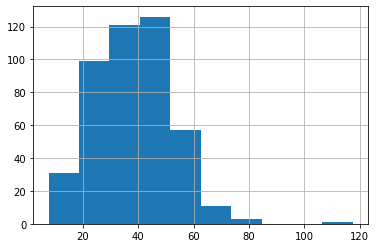

In [24]:
df['uf_m2'].hist() # hay valores que pueden afectar la regresión

In [25]:
df[df['uf_m2']>90]
 # corresponde a un único registro por lo que lo eliminamos (outlier).


,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
0,10.8,252.5822,1,-33.4646,-70.63046,117.5,2013,3,31


In [26]:
df=df[df['uf_m2']<90] #es eliminado ese registro outlier con esta condicion

<AxesSubplot:>

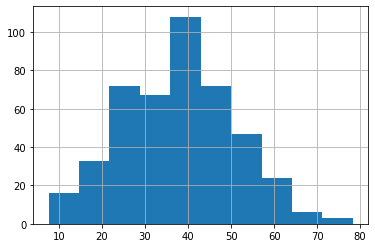

In [27]:
df['uf_m2'].hist() 

In [28]:
#df.loc[296] # registro con index 296 tiene todos sus valores nulos,
# exceptuando el precio m2, por lo que eliminamos el registro

<AxesSubplot:>

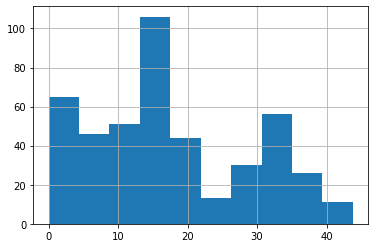

In [29]:
df['a_prop'].hist()

,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
417,31.7,5512.038,1,-33.44095,-70.58458,18.8,2013,6,1
424,31.5,5512.038,1,-33.44095,-70.58458,17.4,2013,5,1
432,18.0,6306.153,1,-33.44743,-70.57516,15.0,2012,9,30
446,30.9,6396.283,1,-33.43375,-70.57883,12.2,2013,0,1
448,17.4,6488.021,1,-33.44719,-70.57353,11.2,2013,6,30


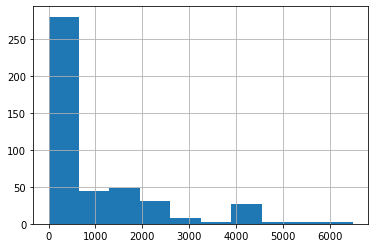

In [30]:
df['dist_m'].hist()
a=df[df['dist_m']>5000]
a

<AxesSubplot:>

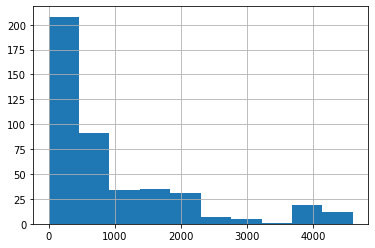

In [31]:
df=df[df['dist_m']<5000]
df['dist_m'].hist()

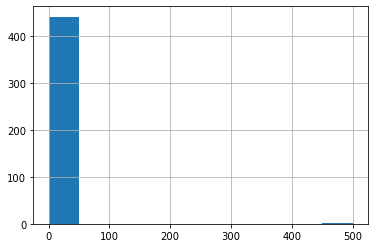

In [32]:
df['t_cerc'].hist()
a=df[df['t_cerc']>100]


<AxesSubplot:>

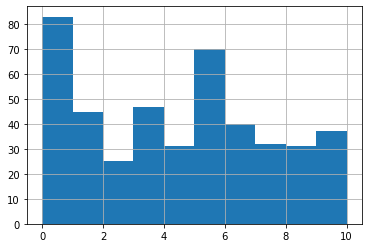

In [33]:
df=df[df['t_cerc']<100]
df['t_cerc'].hist()

,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
1,37.2,186.5101,9,-33.46703,-70.64265,78.3,2013,3,31
2,35.4,318.5292,9,-33.46071,-70.64069,78.0,2013,6,30
3,0.0,292.9978,6,-33.46744,-70.64458,73.6,2013,5,1
4,0.0,292.9978,6,-33.46744,-70.64458,71.0,2012,9,30
5,0.0,292.9978,6,-33.46744,-70.64458,70.1,2013,3,1
...,...,...,...,...,...,...,...,...,...
443,16.1,4066.5870,0,-33.43297,-70.60342,12.9,2012,9,1
444,32.0,1156.7770,0,-33.43935,-70.63046,12.8,2013,0,1
445,16.5,4082.0150,0,-33.43155,-70.60381,12.8,2013,0,1
447,16.0,4066.5870,0,-33.43297,-70.60342,11.6,2012,9,1


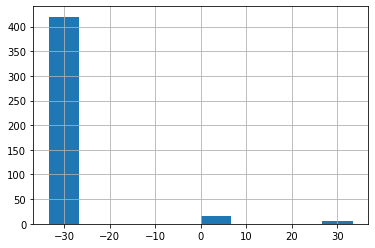

In [34]:
df['lat'].hist()
a=df[df['lat']<0]
a

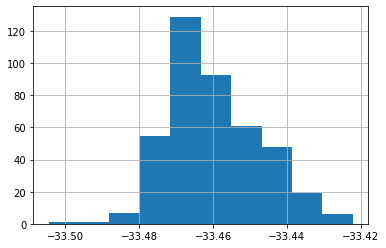

In [35]:
a['lat'].hist()
df=df[df['lat']<0]

<AxesSubplot:>

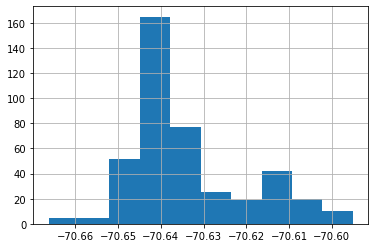

In [36]:
df['long'].hist()
#a=df[df['long']<0]
#a

<AxesSubplot:>

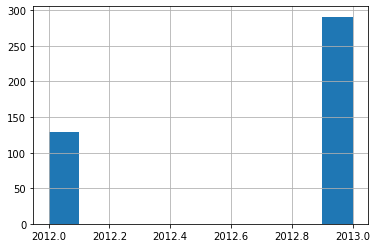

In [37]:
df['year'].hist()

In [38]:
df.corr() #matriz de correlacion entre features. Observamos que latitud y longitud tienen una muy baja
# correlacion con uf_m2, junto con año y día. 


,a_prop,dist_m,t_cerc,lat,long,uf_m2,year,mes,dia
a_prop,1.000000,0.000331,0.047653,-0.079202,0.029402,-0.208992,0.036283,-0.046375,-0.032389
dist_m,0.000331,1.000000,-0.623462,0.572962,0.769078,-0.684205,0.006052,0.051153,0.007711
t_cerc,0.047653,-0.623462,1.000000,-0.433158,-0.443012,0.610963,0.012597,0.007666,-0.024757
lat,-0.079202,0.572962,-0.433158,1.000000,0.378430,-0.550588,-0.020843,-0.012748,0.006086
long,0.029402,0.769078,-0.443012,0.378430,1.000000,-0.518406,-0.019215,0.069290,-0.003048
uf_m2,-0.208992,-0.684205,0.610963,-0.550588,-0.518406,1.000000,0.099521,-0.064610,0.007812
year,0.036283,0.006052,0.012597,-0.020843,-0.019215,0.099521,1.000000,-0.812756,-0.079560
mes,-0.046375,0.051153,0.007666,-0.012748,0.069290,-0.064610,-0.812756,1.000000,0.139600
dia,-0.032389,0.007711,-0.024757,0.006086,-0.003048,0.007812,-0.079560,0.139600,1.000000


In [39]:
(df.corr()['uf_m2'].abs()).sort_values(ascending=True)

dia       0.007812
mes       0.064610
year      0.099521
a_prop    0.208992
long      0.518406
lat       0.550588
t_cerc    0.610963
dist_m    0.684205
uf_m2     1.000000
Name: uf_m2, dtype: float64

In [40]:
# creamos un dataset de prueba quitando las features: dia, mes, año
prueba= df.drop(['dia','mes','year',], axis=1)
prueba.shape

(420, 6)

In [41]:
prueba.loc[290:300]

,a_prop,dist_m,t_cerc,lat,long,uf_m2
290,12.7,170.1289,1,-33.46371,-70.62984,32.9
292,31.5,414.9476,4,-33.47199,-70.64464,32.5
293,39.7,333.3679,9,-33.47016,-70.63932,32.4
294,13.1,1164.8380,4,-33.48156,-70.63406,32.2
295,7.1,2175.0300,3,-33.45305,-70.61254,32.1
297,37.1,918.6357,1,-33.46198,-70.65063,31.9
298,3.9,2147.3760,3,-33.45299,-70.61284,31.7
299,18.2,451.6419,8,-33.45945,-70.64490,31.6
300,38.3,642.6985,3,-33.46559,-70.63713,31.5


<AxesSubplot:xlabel='year'>

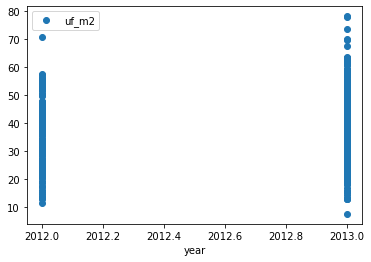

In [42]:
df.plot(x='year', y='uf_m2', style='o')


**Matriz de dispersion. En la diagonal principal se muestran el histograma de la variable correspondiente**

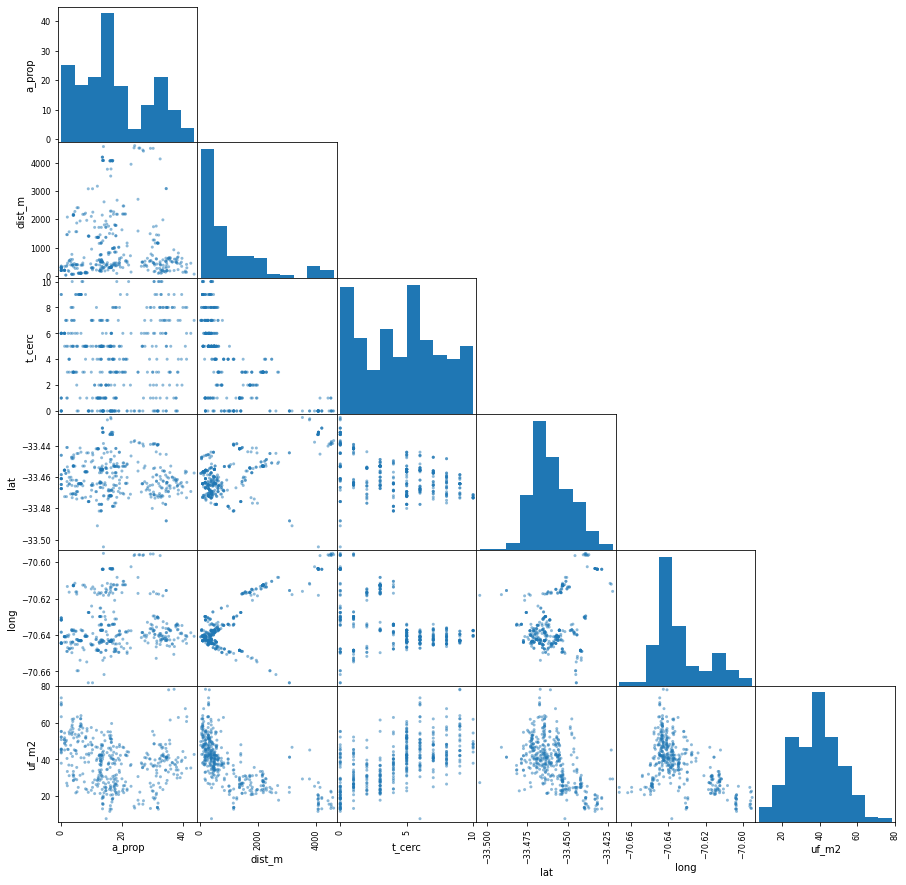

In [43]:
axes=pd.plotting.scatter_matrix(prueba, alpha=0.5, figsize=(15,15), ax=None, grid=False, diagonal='hist', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.05);

for i in range(np.shape(axes)[0]):
    for j in range(np.shape(axes)[1]):
        if i < j:
            axes[i,j].set_visible(False)

In [44]:
X=prueba.drop('uf_m2', axis=1)
y=prueba['uf_m2']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape


((294, 5), (126, 5))

In [46]:
model= XGBRegressor(gpu_id=-1,learning_rate=0.05, gamma=0.3,max_depth=3, n_estimators=100,subsample=0.8, min_child_weight=3)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

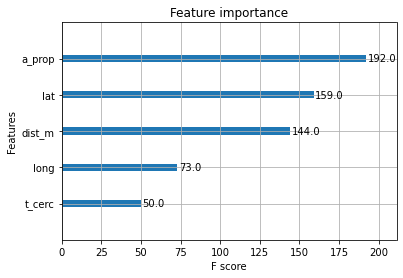

In [47]:
xgb.plot_importance(model, ax=pyplot.gca())

In [48]:
pred_train = model.predict(X_train)

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train, pred_train))

0.8816003871901137


In [50]:
print(mean_squared_error(y_train, pred_train))

19.408659474920164


In [51]:
predict=model.predict(X_test)

In [52]:
print(r2_score(y_test, predict))

0.7140206142469452


In [53]:
print(mean_squared_error(y_test, predict))

47.2802325801132


In [54]:
"""xgboost = XGBRegressor(gpu_id=-1,learning_rate=0.3, max_depth=6, n_estimators=100,subsample=0.8)  # gpu_id=-1



tuned_parameters = {
   'max_depth':[3,4,5,6],
   'min_child_weight':[1,2,3,4,5,6],
   'gamma':[i/10.0 for i in range(0,5)], 
   'learning_rate':[0.01,0.05,0.1,0.2]  #, 'n_estimators':[100, 500,1000]
}

clf = GridSearchCV(xgboost, param_grid = tuned_parameters,cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print( clf.best_params_)
print("Best score found on development set:")
print( clf.best_score_)

# clf.grid_scores_ 
"""
#tuning de parámetros a posteriori. se ejecuta una sola vez

'xgboost = XGBRegressor(gpu_id=-1,learning_rate=0.3, max_depth=6, n_estimators=100,subsample=0.8)  # gpu_id=-1\n\n\n\ntuned_parameters = {\n   \'max_depth\':[3,4,5,6],\n   \'min_child_weight\':[1,2,3,4,5,6],\n   \'gamma\':[i/10.0 for i in range(0,5)], \n   \'learning_rate\':[0.01,0.05,0.1,0.2]  #, \'n_estimators\':[100, 500,1000]\n}\n\nclf = GridSearchCV(xgboost, param_grid = tuned_parameters,cv=5)\nclf.fit(X_train, y_train)\n\nprint("Best parameters set found on development set:")\nprint( clf.best_params_)\nprint("Best score found on development set:")\nprint( clf.best_score_)\n\n# clf.grid_scores_ \n'

In [55]:
model= XGBRegressor(gpu_id=-1,learning_rate=0.05, gamma=0.2,max_depth=4, n_estimators=100,subsample=0.8, min_child_weight=6)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [56]:
pred_train = model.predict(X_train)


In [57]:
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train, pred_train))


0.8971199551037988


In [58]:
r=mean_squared_error(y_train, pred_train, squared=False)
print(r) #RMSE es de 4.1 menor a 7 pedido en el desafío

4.106654833150361


In [59]:
predict=model.predict(X_test)

In [60]:
print(r2_score(y_test, predict))

0.71867424116138


In [61]:
# ingresamos los valores a predecir
lista=[[16.2, 289.3248,5,-36.4671001,-70.64071],
       [13.6, 4082.015, 0,-36.4650120,-70.63201]]
estimar=pd.DataFrame(lista, columns=['a_prop', 'dist_m', 't_cerc', 'lat', 'long'])

In [62]:
estimar.head()

,a_prop,dist_m,t_cerc,lat,long
0,16.2,289.3248,5,-36.467100,-70.64071
1,13.6,4082.0150,0,-36.465012,-70.63201


In [63]:
pre=model.predict(estimar)
pre #valores predichos por el modelo y los precios en UF por metro cuadrado. 

array([47.480236, 30.542458], dtype=float32)

 **valores predichos por el modelo y los precios en UF por metro cuadrado. 47.480236 por m2 para la primera propiedad
 y 30.542458 para la segunda**

--------------------------------------------FIN----------------------------------------------------